In [1]:
from pathlib import Path
import torch
import seaborn as sn
import os
import sys

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
modules_dir = Path().absolute().parent
print(modules_dir)
sys.path.append(str(Path().absolute().parent))
sys.path.append(str(modules_dir))

/Users/andreamancini/MyProjects/ProfileModel


In [3]:
from data.preprocessing import MyDataset, PreprocessData
from config import ModelArgs
from training import TrainingPipeline
from utils.torch_utils import fix_random, get_device

from predict import InferencePipeline

In [4]:
seed = 42
fix_random(seed)

device = get_device()
fpath = "datasets/trx_data.csv"

Device: mps


In [5]:
data, targets = PreprocessData(fpath).get_data()

dataset = MyDataset(data, targets)
dataset.split_data(seed, val_set=True)

class_weights = dataset.compute_class_weights()

model_args = ModelArgs()
model_args.distinct_labels = dataset.labels
model_args.num_class = len(dataset.labels)

Weights per class: tensor([0.8296, 0.9036, 0.9645, 0.6145, 0.8996, 0.9187, 0.9396, 0.9300])


{'A0A137PD51_CONC2_364-470': 3121, 'A0A1C0UXM5_9CYAN_59-160': 1765, 'A0A445ASL5_ARAHY_16-95': 651, 'A0A5A7MNT3_9PROT_18-119': 7059, 'A0A7L2CD13_9PASS_3-102': 1839, 'A0A833VMF7_9POAL_555-649': 1489, 'L5LE17_MYODS_16-90': 1107, 'M4CYC0_BRARP_64-181': 1282}
{'A0A137PD51_CONC2_364-470': 976, 'A0A1C0UXM5_9CYAN_59-160': 551, 'A0A445ASL5_ARAHY_16-95': 203, 'A0A5A7MNT3_9PROT_18-119': 2206, 'A0A7L2CD13_9PASS_3-102': 575, 'A0A833VMF7_9POAL_555-649': 466, 'L5LE17_MYODS_16-90': 346, 'M4CYC0_BRARP_64-181': 400}
{'A0A137PD51_CONC2_364-470': 780, 'A0A1C0UXM5_9CYAN_59-160': 441, 'A0A445ASL5_ARAHY_16-95': 163, 'A0A5A7MNT3_9PROT_18-119': 1765, 'A0A7L2CD13_9PASS_3-102': 460, 'A0A833VMF7_9POAL_555-649': 373, 'L5LE17_MYODS_16-90': 277, 'M4CYC0_BRARP_64-181': 320}
{'train': 18313, 'test': 5723, 'val': 4579} {'train': {'A0A137PD51_CONC2_364-470': 3121, 'A0A1C0UXM5_9CYAN_59-160': 1765, 'A0A445ASL5_ARAHY_16-95': 651, 'A0A5A7MNT3_9PROT_18-119': 7059, 'A0A7L2CD13_9PASS_3-102': 1839, 'A0A833VMF7_9POAL_555-649': 1

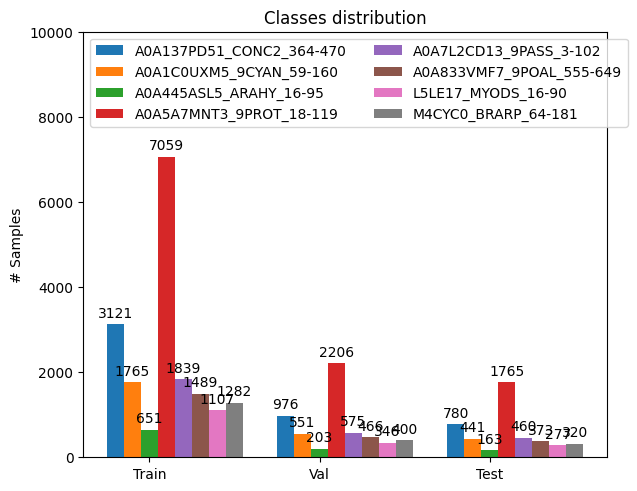

<Figure size 640x480 with 0 Axes>

In [6]:
dataset.plot_distribution()

In [7]:
batch_size = 8

loaders_dict = dataset.get_data_loaders(
    model_name=model_args.esm_name, fpath=fpath, batch_size=batch_size
)

train_loader = loaders_dict['train_loader']
val_loader = loaders_dict['val_loader']
test_loader = loaders_dict['test_loader']

In [8]:
from training import TrainArgs

train_args = TrainArgs()
train_args.nametrain = "finetune TRX"
train_args.l_rate = 1e-3
train_args.epochs = 10
train_args.criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

pipeline = TrainingPipeline(seed=seed, mode='manual', device=device)

results = pipeline(
    train_loader=train_loader, val_loader=val_loader, model_args=model_args, train_args=train_args
    )

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 257,768 || all params: 34,254,497 || trainable%: 0.7525


 11%|█         | 249/2290 [08:27<1:08:58,  2.03s/it, lr=0.001, train_loss=1.23, train_acc=60.7, MPS mem=18.8]

In [ ]:



pipeline = InferencePipeline(seed=seed, mode='manual', device=device)

pipeline(
    data=test_loader,'model','model_args'
    )

In [ ]:


def build_confusion_matrix(y_true, y_pred, tags):
    ''' Builds and plots the confusion matrix '''
    cf = confusion_matrix(y_true, y_pred, normalize='true')
    df_cm = pd.DataFrame(cf, index=tags, columns=tags)
    sn.heatmap(df_cm, annot=True, cbar=True)
    return df_cm

build_confusion_matrix(y_true, y_pred, distinct_labels)